![](https://storage.googleapis.com/kaggle-competitions/kaggle/3338/media/gate.png)

## Amazon.com - Employee Access Challenge

When an employee at any company starts work, they first need to obtain the computer access necessary to fulfill their role. This access may allow an employee to read/manipulate resources through various applications or web portals. It is assumed that employees fulfilling the functions of a given role will access the same or similar resources. It is often the case that employees figure out the access they need as they encounter roadblocks during their daily work (e.g. not able to log into a reporting portal). A knowledgeable supervisor then takes time to manually grant the needed access in order to overcome access obstacles. As employees move throughout a company, this access discovery/recovery cycle wastes a nontrivial amount of time and money.

There is a considerable amount of data regarding an employee’s role within an organization and the resources to which they have access. Given the data related to current employees and their provisioned access, models can be built that automatically determine access privileges as employees enter and leave roles within a company. These auto-access models seek to minimize the human involvement required to grant or revoke employee access.

## Kernel's motivations

In this kernel we are going to show how deep learning (using TensorFlow 2.0 and Keras) can be effectively used when the problem involved regards tabular data. We will compare a deep neural network solution (DNN) to the best in class gradient boosting machine (GBM) algorithm when high cardinality variables are present and you will discover how not only a DNN solution is comparable, but also how it can integrate nicely with a GBM solution.

In [1]:
# Assuring you have the most recent CatBoost release
!pip install catboost -U

     |████████████████████████████████| 63.6MB 50.2MB/s 
  Found existing installation: catboost 0.17.3
    Uninstalling catboost-0.17.3:
      Successfully uninstalled catboost-0.17.3


In [2]:
# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifiers
from catboost import CatBoostClassifier, Pool

# Model selection
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import make_scorer

In [3]:
# Loading data directly from CatBoost
from catboost.datasets import amazon

X, Xt = amazon()

y = X["ACTION"].apply(lambda x: 1 if x == 1 else 0).values
X.drop(["ACTION"], axis=1, inplace=True)

In [4]:
# Transforming all the labels of all variables
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in range(X.shape[1])]

for col, column in enumerate(X.columns):
    label_encoders[col].fit(X[column].append(Xt[column]))
    X[column] = label_encoders[col].transform(X[column])
    Xt[column] = label_encoders[col].transform(Xt[column])

In [5]:
# Enconding frequencies instead of labels (so we have some numeric variables)

def frequency_encoding(column, df, df_test=None):
    frequencies = df[column].value_counts().reset_index()
    df_values = df[[column]].merge(frequencies, how='left', 
                                   left_on=column, right_on='index').iloc[:,-1].values
    if df_test is not None:
        df_test_values = df_test[[column]].merge(frequencies, how='left', 
                                                 left_on=column, right_on='index').fillna(1).iloc[:,-1].values
    else:
        df_test_values = None
    return df_values, df_test_values

for column in X.columns:
    train_values, test_values = frequency_encoding(column, X, Xt)
    X[column+'_counts'] = train_values
    Xt[column+'_counts'] = test_values

In [6]:
# Pointing out which variables are categorical and which are numeric
categorical_variables = [col for col in X.columns if '_counts' not in col]
numeric_variables = [col for col in X.columns if '_counts' in col]

In [7]:
X.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,RESOURCE_counts,MGR_ID_counts,ROLE_ROLLUP_1_counts,ROLE_ROLLUP_2_counts,ROLE_DEPTNAME_counts,ROLE_TITLE_counts,ROLE_FAMILY_DESC_counts,ROLE_FAMILY_counts,ROLE_CODE_counts
0,3050,4440,21,65,319,4,7,65,4,3,55,21407,4424,72,3583,6896,10980,3583
1,644,162,21,69,310,34,62,67,38,30,10,21407,3945,159,81,12,1287,81
2,2706,1679,50,58,14,0,2590,3,0,2,3,184,184,546,1256,33,2636,1256
3,2615,931,21,69,184,22,2357,65,23,1,62,21407,3945,190,4649,1244,10980,4649
4,3616,1010,15,13,160,70,380,4,77,8,9,276,138,45,75,19,362,75


In [8]:
Xt.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,RESOURCE_counts,MGR_ID_counts,ROLE_ROLLUP_1_counts,ROLE_ROLLUP_2_counts,ROLE_DEPTNAME_counts,ROLE_TITLE_counts,ROLE_FAMILY_DESC_counts,ROLE_FAMILY_counts,ROLE_CODE_counts
0,1,5481,4250,33,38,13,0,34,3,0,13,5.0,221.0,221.0,1135.0,1256.0,114.0,2636.0,1256.0
1,2,3283,655,21,67,70,55,267,13,59,2,17.0,21407.0,2641.0,267.0,121.0,25.0,1294.0,121.0
2,3,4992,298,21,65,155,13,2813,62,13,10,52.0,21407.0,4424.0,34.0,64.0,154.0,224.0,64.0
3,4,3746,2297,21,59,53,124,959,28,133,2,45.0,21407.0,2547.0,532.0,289.0,30.0,465.0,289.0
4,5,3507,3295,21,69,161,27,2799,14,28,204,19.0,21407.0,3945.0,543.0,376.0,222.0,2690.0,376.0


In [9]:
# Counting unique values of categorical variables
X[categorical_variables].nunique()

RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

In [10]:
# Describing numeric variables
X[numeric_variables].describe()

,RESOURCE_counts,MGR_ID_counts,ROLE_ROLLUP_1_counts,ROLE_ROLLUP_2_counts,ROLE_DEPTNAME_counts,ROLE_TITLE_counts,ROLE_FAMILY_DESC_counts,ROLE_FAMILY_counts,ROLE_CODE_counts
count,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000
mean,83.664408,20.219995,14078.222558,1898.867741,260.167384,1394.336629,1597.602643,4597.008178,1394.336629
std,164.604062,18.611747,10060.598792,1591.903681,253.684148,1692.657706,2747.932995,4598.402211,1692.657706
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000
25%,3.000000,7.000000,334.000000,257.000000,83.000000,164.000000,16.000000,783.000000,164.000000
50%,13.000000,15.000000,21407.000000,1665.000000,162.000000,467.000000,128.000000,2400.000000,467.000000
75%,72.000000,27.000000,21407.000000,3945.000000,335.000000,3583.000000,670.000000,10980.000000,3583.000000
max,839.000000,152.000000,21407.000000,4424.000000,1135.000000,4649.000000,6896.000000,10980.000000,4649.000000


# Using CatBoost

In [11]:
# Initializing a CatBoostClassifier with best parameters
best_params = {'bagging_temperature': 0.6,
               'border_count': 200,
               'depth': 8,
               'iterations': 350,
               'l2_leaf_reg': 30,
               'learning_rate': 0.30,
               'random_strength': 0.01,
               'scale_pos_weight': 0.48}

catb = CatBoostClassifier(**best_params,
                          loss_function='Logloss',
                          eval_metric = 'AUC',
                          nan_mode='Min',
                          thread_count=2,
                          verbose = False)

In [12]:
# Setting a 5-fold stratified cross-validation (note: shuffle=True)
SEED = 42
FOLDS = 5

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

In [13]:
# CV interations

roc_auc = list()
average_precision = list()
oof = np.zeros(len(X))
best_iteration = list()

for train_idx, test_idx in skf.split(X, y):
    X_train, y_train = X.iloc[train_idx, :], y[train_idx]
    X_test, y_test = X.iloc[test_idx, :], y[test_idx]
    
    train = Pool(data=X_train, 
             label=y_train,            
             feature_names=list(X_train.columns),
             cat_features=categorical_variables)

    test = Pool(data=X_test, 
                label=y_test,
                feature_names=list(X_test.columns),
                cat_features=categorical_variables)

    catb.fit(train,
             verbose_eval=100, 
             early_stopping_rounds=50,
             eval_set=test,
             use_best_model=True,
             #task_type = "GPU",
             plot=False)
    
    best_iteration.append(catb.best_iteration_)
    preds = catb.predict_proba(X_test)
    
    oof[test_idx] = preds[:,1]
    
    roc_auc.append(roc_auc_score(y_true=y_test, y_score=preds[:,1]))
    average_precision.append(average_precision_score(y_true=y_test, y_score=preds[:,1]))

0:	test: 0.6331238	best: 0.6331238 (0)	total: 163ms	remaining: 57s
100:	test: 0.8871443	best: 0.8871443 (100)	total: 10.1s	remaining: 25s
200:	test: 0.8862012	best: 0.8891918 (158)	total: 20.2s	remaining: 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.889191775
bestIteration = 158

Shrink model to first 159 iterations.
0:	test: 0.6448479	best: 0.6448479 (0)	total: 110ms	remaining: 38.5s
100:	test: 0.8877733	best: 0.8919587 (73)	total: 9.42s	remaining: 23.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8919586618
bestIteration = 73

Shrink model to first 74 iterations.
0:	test: 0.6284797	best: 0.6284797 (0)	total: 106ms	remaining: 37s
100:	test: 0.8899182	best: 0.8902680 (83)	total: 10.2s	remaining: 25.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8902679805
bestIteration = 83

Shrink model to first 84 iterations.
0:	test: 0.6505088	best: 0.6505088 (0)	total: 105ms	remaining: 36.6s
100:	test: 0.8944298	best: 0.8956

In [14]:
print("Average cv roc auc score %0.3f ± %0.3f" % (np.mean(roc_auc), np.std(roc_auc)))
print("Average cv roc average precision %0.3f ± %0.3f" % (np.mean(average_precision), np.std(average_precision)))

print("Roc auc score OOF %0.3f" % roc_auc_score(y_true=y, y_score=oof))
print("Average precision OOF %0.3f" % average_precision_score(y_true=y, y_score=oof))


Average cv roc auc score 0.889 ± 0.006
Average cv roc average precision 0.990 ± 0.001
Roc auc score OOF 0.889
Average precision OOF 0.989


In [15]:
# Using catboost on all the data for predictions

best_params = {'bagging_temperature': 0.6,
               'border_count': 200,
               'depth': 8,
               'iterations': int(np.median(best_iteration) * 1.3),
               'l2_leaf_reg': 30,
               'learning_rate': 0.30,
               'random_strength': 0.01,
               'scale_pos_weight': 0.48}

catb = CatBoostClassifier(**best_params,
                          loss_function='Logloss',
                          eval_metric = 'AUC',
                          nan_mode='Min',
                          thread_count=2,
                          verbose = False)

train = Pool(data=X, 
             label=y,            
             feature_names=list(X_train.columns),
             cat_features=categorical_variables)

catb.fit(train,
         verbose_eval=100,
         #task_type = "GPU",
         plot=False)

submission = pd.DataFrame(Xt.id)
Xt_pool = Pool(data=Xt[list(X_train.columns)],
               feature_names=list(X_train.columns),
               cat_features=categorical_variables)
submission['Action'] = catb.predict_proba(Xt_pool)[:,1]
submission.to_csv("catboost_submission.csv", index=False)

cat_boost_submission = submission.copy()

0:	total: 37.7ms	remaining: 4s
100:	total: 3.37s	remaining: 200ms
106:	total: 3.56s	remaining: 0us


# Using deep learning

In [16]:
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation, LeakyReLU

# Add the GELU function to Keras 
# (see: https://datascience.stackexchange.com/questions/49522/what-is-gelu-activation)

def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Activation(gelu)})

# Add leaky-relu so we can use it as a string
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

In [17]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.layers import Input, Embedding, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, concatenate, Concatenate, Lambda, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Reshape, MaxPooling1D,BatchNormalization, AveragePooling1D, Conv1D
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1_l2
from keras.losses import binary_crossentropy

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [18]:
# Parametric architecture

def tabular_dnn(numeric_variables, categorical_variables, categorical_counts,
                feature_selection_dropout=0.2, categorical_dropout=0.1,
                first_dense = 256, second_dense = 256, dense_dropout = 0.2, 
                activation_type=gelu):
    
    numerical_inputs = Input(shape=(len(numeric_variables),))
    numerical_normalization = BatchNormalization()(numerical_inputs)
    numerical_feature_selection = Dropout(feature_selection_dropout)(numerical_normalization)

    categorical_inputs = []
    categorical_embeddings = []
    for category in  categorical_variables:
        categorical_inputs.append(Input(shape=[1], name=category))
        category_counts = categorical_counts[category]
        categorical_embeddings.append(
            Embedding(category_counts+1, 
                      int(np.log1p(category_counts)+1), 
                      name = category + "_embed")(categorical_inputs[-1]))

    categorical_logits = Concatenate(name = "categorical_conc")([Flatten()(SpatialDropout1D(categorical_dropout)(cat_emb)) 
                                                                 for cat_emb in categorical_embeddings])

    x = concatenate([numerical_feature_selection, categorical_logits])
    x = Dense(first_dense, activation=activation_type)(x)
    x = Dropout(dense_dropout)(x)  
    x = Dense(second_dense, activation=activation_type)(x)
    x = Dropout(dense_dropout)(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model([numerical_inputs] + categorical_inputs, output)
    
    return model

In [19]:
# Useful functions

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

def mAP(y_true, y_pred):
    return tf.py_func(average_precision_score, (y_true, y_pred), tf.double)

def compile_model(model, loss, metrics, optimizer):
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

def plot_keras_history(history, measures):
    """
    history: Keras training history
    measures = list of names of measures
    """
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize=(15, 5))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label="Train "+measure)
        panel.plot(history.epoch, history.history["val_"+measure], label="Validation "+measure)
        panel.set(xlabel='epochs', ylabel=measure)
        panel.legend()
        
    plt.show(fig)

In [20]:
def to_arrays(x, row_index=None):
    """
    given a pandas dataframe, returns a numpy array for each columns
    """
    if row_index is None:
        return [x.iloc[:, col_index].to_numpy() for col_index in range(x.shape[1])]
    else:
        return [x.iloc[row_index, col_index].to_numpy() for col_index in range(x.shape[1])]

def batch_generator(X, y, numeric, categorical, cv=5, batch_size=64, random_state=None):
    '''
    Returns a batch from X, y
    random_state allows determinism
    different scikit-learn CV strategies are possible
    '''
    folds = len(y) // batch_size
    if isinstance(cv, int):
        kf = StratifiedKFold(n_splits=cv, 
                              shuffle=True, 
                              random_state=random_state)
    else:
        kf = cv
    
    while True:
        for _, train_index in kf.split(X, y):
            numeric_input = X[numeric].iloc[train_index].to_numpy(dtype=np.float32)
            categorical_input = to_arrays(X[categorical], train_index)
            target = y[train_index]
            yield [numeric_input] + categorical_input, target

In [21]:
# Global training settings

SEED = 42
FOLDS = 5
BATCH_SIZE = 512

In [22]:
# Defining callbacks

measure_to_monitor = 'val_auroc' 
modality = 'max'

early_stopping = EarlyStopping(monitor=measure_to_monitor, 
                                   mode=modality, 
                                   patience=3, 
                                   verbose=0)

model_checkpoint = ModelCheckpoint('best.model', 
                                   monitor=measure_to_monitor, 
                                   mode=modality, 
                                   save_best_only=True, 
                                   verbose=0)

In [23]:
# We enumerate the levels for each categorical variable
categorical_levels = {cat:len(set(X[cat].unique())|set(Xt[cat].unique())) for cat in categorical_variables}
print(categorical_levels)

{'RESOURCE': 7518, 'MGR_ID': 4913, 'ROLE_ROLLUP_1': 130, 'ROLE_ROLLUP_2': 183, 'ROLE_DEPTNAME': 476, 'ROLE_TITLE': 361, 'ROLE_FAMILY_DESC': 2951, 'ROLE_FAMILY': 68, 'ROLE_CODE': 361}


Epoch 1/30
51/51 [==============================] - 14s 278ms/step - loss: 0.6060 - auroc: 0.4951 - mAP: 0.9445 - val_loss: 0.4232 - val_auroc: 0.5319 - val_mAP: 0.9463
Epoch 2/30
51/51 [==============================] - 11s 208ms/step - loss: 0.4195 - auroc: 0.5217 - mAP: 0.9486 - val_loss: 0.3177 - val_auroc: 0.5399 - val_mAP: 0.9466
Epoch 3/30
51/51 [==============================] - 11s 209ms/step - loss: 0.2758 - auroc: 0.5637 - mAP: 0.9537 - val_loss: 0.2426 - val_auroc: 0.5561 - val_mAP: 0.9477
Epoch 4/30
51/51 [==============================] - 11s 208ms/step - loss: 0.2198 - auroc: 0.6485 - mAP: 0.9641 - val_loss: 0.2170 - val_auroc: 0.6245 - val_mAP: 0.9581
Epoch 5/30
51/51 [==============================] - 11s 208ms/step - loss: 0.2012 - auroc: 0.7489 - mAP: 0.9756 - val_loss: 0.2052 - val_auroc: 0.7071 - val_mAP: 0.9694
Epoch 6/30
51/51 [==============================] - 11s 208ms/step - loss: 0.1865 - auroc: 0.8310 - mAP: 0.9843 - val_loss: 0.1948 - val_auroc: 0.7780 - va

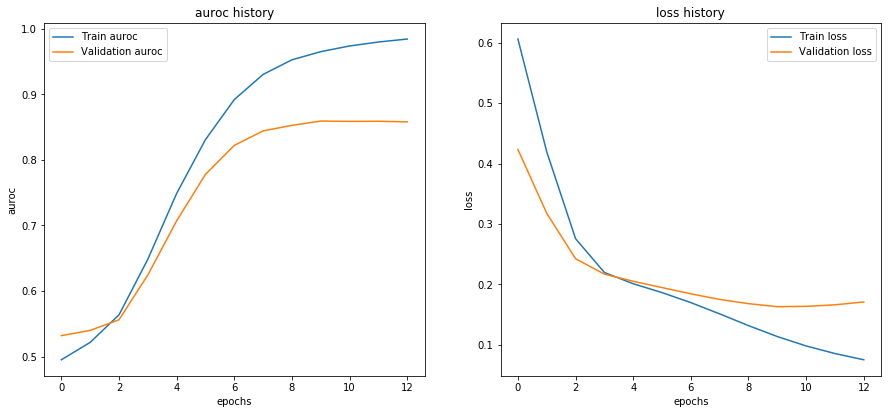

6555/6555 [==============================] - 0s 52us/sample
Epoch 1/30
51/51 [==============================] - 14s 270ms/step - loss: 0.5967 - auroc: 0.4939 - mAP: 0.9440 - val_loss: 0.4052 - val_auroc: 0.5306 - val_mAP: 0.9487
Epoch 2/30
51/51 [==============================] - 11s 206ms/step - loss: 0.4221 - auroc: 0.5032 - mAP: 0.9452 - val_loss: 0.3163 - val_auroc: 0.5438 - val_mAP: 0.9500
Epoch 3/30
51/51 [==============================] - 10s 205ms/step - loss: 0.2773 - auroc: 0.5606 - mAP: 0.9529 - val_loss: 0.2367 - val_auroc: 0.5933 - val_mAP: 0.9551
Epoch 4/30
51/51 [==============================] - 11s 208ms/step - loss: 0.2176 - auroc: 0.6670 - mAP: 0.9666 - val_loss: 0.2112 - val_auroc: 0.6741 - val_mAP: 0.9665
Epoch 5/30
51/51 [==============================] - 11s 208ms/step - loss: 0.1981 - auroc: 0.7715 - mAP: 0.9784 - val_loss: 0.2000 - val_auroc: 0.7560 - val_mAP: 0.9749
Epoch 6/30
51/51 [==============================] - 11s 212ms/step - loss: 0.1824 - auroc: 0.85

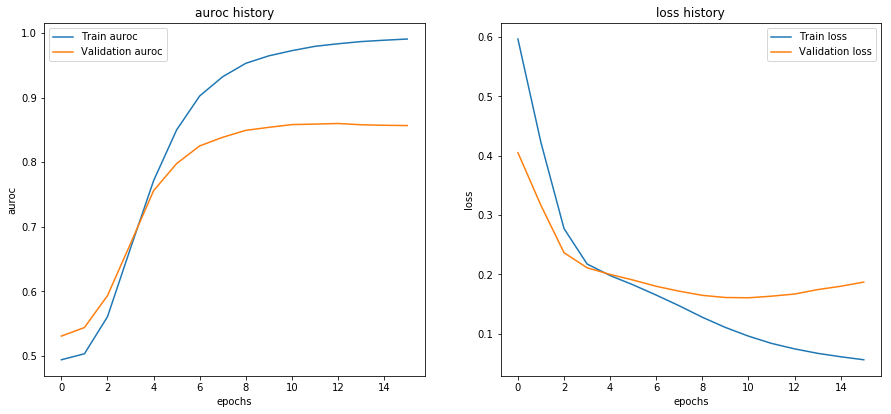

6555/6555 [==============================] - 0s 57us/sample
Epoch 1/30
51/51 [==============================] - 14s 271ms/step - loss: 0.6065 - auroc: 0.5403 - mAP: 0.9502 - val_loss: 0.4042 - val_auroc: 0.5369 - val_mAP: 0.9484
Epoch 2/30
51/51 [==============================] - 10s 201ms/step - loss: 0.4227 - auroc: 0.5407 - mAP: 0.9498 - val_loss: 0.3135 - val_auroc: 0.5424 - val_mAP: 0.9486
Epoch 3/30
51/51 [==============================] - 10s 201ms/step - loss: 0.2772 - auroc: 0.5730 - mAP: 0.9541 - val_loss: 0.2380 - val_auroc: 0.5821 - val_mAP: 0.9538
Epoch 4/30
51/51 [==============================] - 10s 201ms/step - loss: 0.2192 - auroc: 0.6570 - mAP: 0.9650 - val_loss: 0.2137 - val_auroc: 0.6468 - val_mAP: 0.9631
Epoch 5/30
51/51 [==============================] - 10s 202ms/step - loss: 0.2003 - auroc: 0.7556 - mAP: 0.9764 - val_loss: 0.2019 - val_auroc: 0.7397 - val_mAP: 0.9743
Epoch 6/30
51/51 [==============================] - 10s 202ms/step - loss: 0.1843 - auroc: 0.84

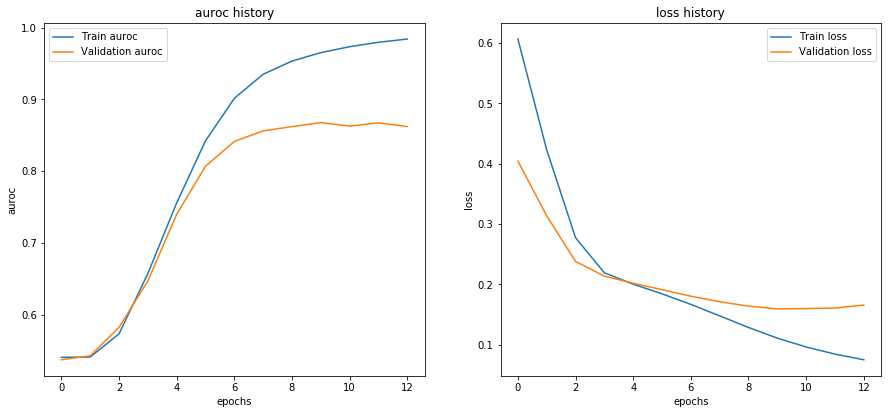

6553/6553 [==============================] - 0s 60us/sample
Epoch 1/30
51/51 [==============================] - 14s 277ms/step - loss: 0.5921 - auroc: 0.5502 - mAP: 0.9508 - val_loss: 0.3733 - val_auroc: 0.5534 - val_mAP: 0.9507
Epoch 2/30
51/51 [==============================] - 10s 200ms/step - loss: 0.4119 - auroc: 0.5319 - mAP: 0.9487 - val_loss: 0.3018 - val_auroc: 0.5721 - val_mAP: 0.9531
Epoch 3/30
51/51 [==============================] - 10s 205ms/step - loss: 0.2724 - auroc: 0.5683 - mAP: 0.9539 - val_loss: 0.2332 - val_auroc: 0.6162 - val_mAP: 0.9584
Epoch 4/30
51/51 [==============================] - 12s 228ms/step - loss: 0.2192 - auroc: 0.6503 - mAP: 0.9645 - val_loss: 0.2091 - val_auroc: 0.6935 - val_mAP: 0.9689
Epoch 5/30
51/51 [==============================] - 10s 203ms/step - loss: 0.2011 - auroc: 0.7505 - mAP: 0.9763 - val_loss: 0.1989 - val_auroc: 0.7649 - val_mAP: 0.9771
Epoch 6/30
51/51 [==============================] - 10s 204ms/step - loss: 0.1857 - auroc: 0.83

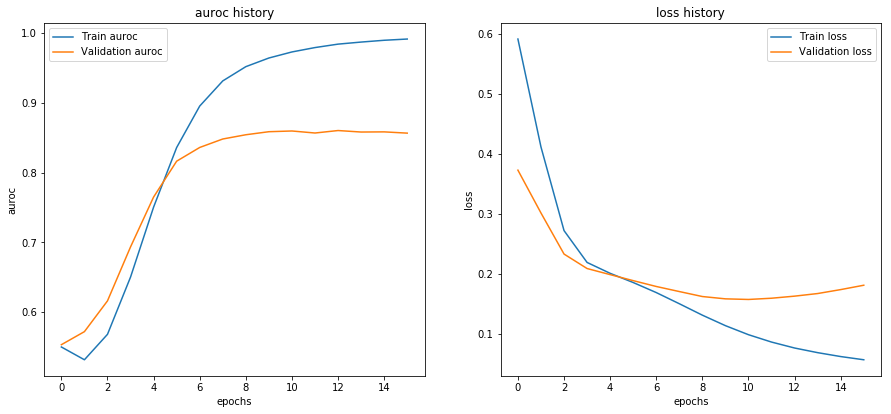

6553/6553 [==============================] - 0s 69us/sample
Epoch 1/30
51/51 [==============================] - 15s 296ms/step - loss: 0.6016 - auroc: 0.5703 - mAP: 0.9553 - val_loss: 0.3685 - val_auroc: 0.5271 - val_mAP: 0.9471
Epoch 2/30
51/51 [==============================] - 10s 201ms/step - loss: 0.4170 - auroc: 0.5541 - mAP: 0.9523 - val_loss: 0.3054 - val_auroc: 0.5300 - val_mAP: 0.9475
Epoch 3/30
51/51 [==============================] - 10s 199ms/step - loss: 0.2726 - auroc: 0.5713 - mAP: 0.9548 - val_loss: 0.2399 - val_auroc: 0.5582 - val_mAP: 0.9514
Epoch 4/30
51/51 [==============================] - 10s 200ms/step - loss: 0.2184 - auroc: 0.6497 - mAP: 0.9651 - val_loss: 0.2170 - val_auroc: 0.6240 - val_mAP: 0.9603
Epoch 5/30
51/51 [==============================] - 10s 200ms/step - loss: 0.1999 - auroc: 0.7552 - mAP: 0.9774 - val_loss: 0.2027 - val_auroc: 0.7377 - val_mAP: 0.9752
Epoch 6/30
51/51 [==============================] - 10s 200ms/step - loss: 0.1837 - auroc: 0.84

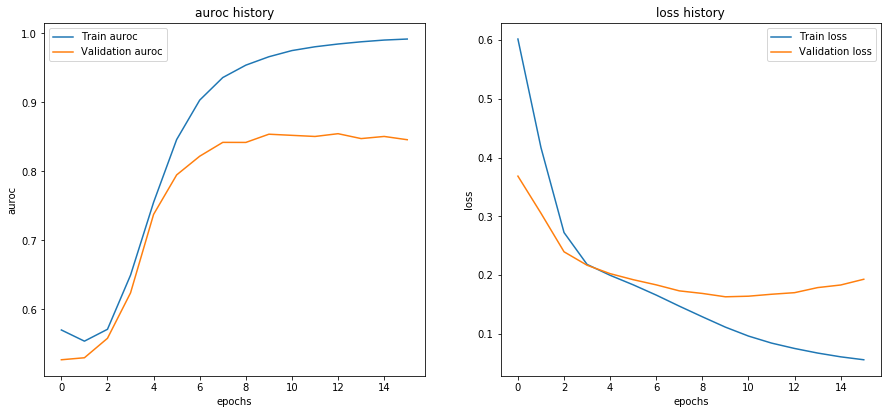

6553/6553 [==============================] - 0s 70us/sample


In [24]:
# Setting the CV strategy
skf = StratifiedKFold(n_splits=FOLDS, 
                      shuffle=True, 
                      random_state=SEED)

# CV Iteration
roc_auc = list()
average_precision = list()
oof = np.zeros(len(X))
best_iteration = list()

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    
    model = tabular_dnn(numeric_variables, categorical_variables,
                        categorical_levels, 
                        feature_selection_dropout=0.1,
                        categorical_dropout=0.1,
                        first_dense = 256,
                        second_dense = 256,
                        dense_dropout = 0.1)
    
    model = compile_model(model, binary_crossentropy, [auroc, mAP], Adam(learning_rate=0.0001))
    
    train_batch = batch_generator(X.iloc[train_idx], 
                              y[train_idx],
                              numeric_variables,
                              categorical_variables,
                              batch_size=BATCH_SIZE,
                              random_state=SEED)
    
    val_batch = batch_generator(X.iloc[test_idx], 
                              y[test_idx],
                              numeric_variables,
                              categorical_variables,
                              batch_size=BATCH_SIZE,
                              random_state=SEED)
    
    train_steps = len(y[train_idx]) // BATCH_SIZE
    
    validation_steps = len(y[test_idx]) // BATCH_SIZE
    
    history = model.fit_generator(train_batch,
                                  validation_data=val_batch,
                                  epochs=30,
                                  steps_per_epoch=train_steps,
                                  validation_steps=validation_steps,
                                  callbacks=[model_checkpoint, early_stopping],
                                  class_weight=[1.0, (np.sum(y==0) / np.sum(y==1))],
                                  verbose=1)
    
    print("\nFOLD %i" % fold)
    plot_keras_history(history, measures=['auroc', 'loss'])
    
    best_iteration.append(np.argmax(history.history['val_auroc']) + 1)
    preds = model.predict([X.iloc[test_idx][numeric_variables].to_numpy(dtype=np.float32)] 
                              + to_arrays(X.iloc[test_idx][categorical_variables]),
                          verbose=1,
                          batch_size=1024).flatten()

    oof[test_idx] = preds

    roc_auc.append(roc_auc_score(y_true=y[test_idx], y_score=preds))
    average_precision.append(average_precision_score(y_true=y[test_idx], y_score=preds))

In [25]:
print("Average cv roc auc score %0.3f ± %0.3f" % (np.mean(roc_auc), np.std(roc_auc)))
print("Average cv roc average precision %0.3f ± %0.3f" % (np.mean(average_precision), np.std(average_precision)))

print("Roc auc score OOF %0.3f" % roc_auc_score(y_true=y, y_score=oof))
print("Average precision OOF %0.3f" % average_precision_score(y_true=y, y_score=oof))

Average cv roc auc score 0.856 ± 0.005
Average cv roc average precision 0.986 ± 0.000
Roc auc score OOF 0.853
Average precision OOF 0.986


In [26]:
# We train on all the examples, using a rule of thumb for the number of iterations

train_batch = batch_generator(X, y,
                              numeric_variables,
                              categorical_variables,
                              batch_size=BATCH_SIZE,
                              random_state=SEED)

train_steps = len(y) // BATCH_SIZE

history = model.fit_generator(train_batch,
                              epochs=int(np.median(best_iteration)),
                              steps_per_epoch=train_steps,
                              class_weight=[1.0, (np.sum(y==0) / np.sum(y==1))],
                              verbose=1)

Epoch 1/13
64/64 [==============================] - 15s 241ms/step - loss: 0.0767 - auroc: 0.9691 - mAP: 0.9975
Epoch 2/13
64/64 [==============================] - 15s 234ms/step - loss: 0.0708 - auroc: 0.9760 - mAP: 0.9982
Epoch 3/13
64/64 [==============================] - 15s 233ms/step - loss: 0.0652 - auroc: 0.9815 - mAP: 0.9987
Epoch 4/13
64/64 [==============================] - 15s 231ms/step - loss: 0.0602 - auroc: 0.9855 - mAP: 0.9990
Epoch 5/13
64/64 [==============================] - 15s 229ms/step - loss: 0.0566 - auroc: 0.9881 - mAP: 0.9992
Epoch 6/13
64/64 [==============================] - 15s 237ms/step - loss: 0.0529 - auroc: 0.9901 - mAP: 0.9994
Epoch 7/13
64/64 [==============================] - 16s 246ms/step - loss: 0.0508 - auroc: 0.9913 - mAP: 0.9994
Epoch 8/13
64/64 [==============================] - 15s 234ms/step - loss: 0.0485 - auroc: 0.9923 - mAP: 0.9995
Epoch 9/13
64/64 [==============================] - 15s 231ms/step - loss: 0.0463 - auroc: 0.9932 - mAP:

In [27]:
# Predicting and submission

preds = model.predict([Xt[numeric_variables].to_numpy(dtype=np.float32)] 
                      + to_arrays(Xt[categorical_variables]),
                      verbose=1,
                      batch_size=1024).flatten()

submission = pd.DataFrame(Xt.id)
submission['Action'] = preds
submission.to_csv("tabular_dnn_submission.csv", index=False)

tabular_dnn_submission = submission.copy()

58921/58921 [==============================] - 2s 27us/sample


## Blending together the GBM and DNN solutions

In [28]:
from scipy.stats import rankdata

# We use normalized ranks because probabilities emissions from the two models may differ
dnn_rank = rankdata(tabular_dnn_submission.Action, method='dense') / len(Xt)
cat_rank = rankdata(cat_boost_submission.Action, method='dense') / len(Xt)

submission = pd.DataFrame(Xt.id)
submission['Action'] = 0.5 * dnn_rank + 0.5 * cat_rank 
submission.to_csv("blended_submission.csv", index=False)